In [20]:
# %load /home/jonathan/.ipython/profile_default/startup/01-setup.py
# start up settings for jupyter notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys

# use plt.style.available() to check out available styles
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.size'] = 15.0
plt.rcParams['axes.labelsize'] = 15.0
plt.rcParams['xtick.labelsize'] = 15.0
plt.rcParams['ytick.labelsize'] = 15.0
plt.rcParams['legend.fontsize'] = 15.0

%matplotlib inline

# set the max column width
pd.options.display.max_colwidth = 1000

# to avoid have warnings from chained assignments
pd.options.mode.chained_assignment = None


In [21]:
idx = pd.IndexSlice

import matplotlib.patches as mpatches
import matplotlib.lines as mlines

### Importing the data

In [22]:
fp = '../../prediction-data/final-data.csv'
uniq_fp = '../../prediction-data/uniq-final-data.csv'

base_df = pd.read_csv(fp, header=[0, 1])
base_df.rename(columns={
    'Unnamed: 0_level_1': '',
    'Unnamed: 1_level_1': '',
    'Unnamed: 2_level_1': '',
    'Unnamed: 3_level_1': ''
}, level=1, inplace=True)

uniq_base_df = pd.read_csv(uniq_fp, header=[0, 1])
uniq_base_df.rename(columns={
    'Unnamed: 0_level_1': '',
    'Unnamed: 1_level_1': '',
    'Unnamed: 2_level_1': '',
    'Unnamed: 3_level_1': ''
}, level=1, inplace=True)

def convert_time_cols(df):
    # convert time columns from us to s
    time_cols = list(filter(lambda c: 'time' in c.lower() and not 'number of times' in c.lower(), df.columns.get_level_values(level=1)))
    for time_col in time_cols:
        df.loc[:, (time_col, 'astar')] /= 1000000
        df.loc[:, (time_col, 'inc3')] /= 1000000
        df.loc[:, (time_col, 'recomp-astar')] /= 1000000
        df.loc[:, (time_col, 'recomp-inc3')] /= 1000000

    # rename from us to s
    renamed_time_cols = list(map(lambda col: col.replace('(us)', '(s)'), time_cols))
    renamed_cols_dict = dict(zip(time_cols, renamed_time_cols))
    df.rename(columns=renamed_cols_dict, level=0, inplace=True)
    df.rename(columns=renamed_cols_dict, level=1, inplace=True)
    
convert_time_cols(base_df)
convert_time_cols(uniq_base_df)

base_df.set_index(['model', 'log', 'decomposition', 'SP label'], inplace=True)
uniq_base_df.set_index(['model', 'log', 'decomposition', 'SP label'], inplace=True)

print('Base df shape: {}'.format(base_df.shape))
print('Uniq base df shape: {}'.format(uniq_base_df.shape))

/home/jonathan/2018/code/alignment-algorithm-classifier/alignclf-venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Base df shape: (245478, 258)
Uniq base df shape: (185848, 258)


### Map the class names to values

In [23]:
class_map = {
    'astar': 0,
    'inc3': 1,
    'recomp-astar': 2,
    'recomp-inc3': 3
}

base_df.loc[:, ('Min', 'Total Time including setup (s) - id')] = base_df.loc[: , idx['Min', 'Total Time including setup (s)']].map(class_map)
base_df.loc[:, ('is_valid', 'all')] = base_df.loc[:, idx[('is_valid'), ('astar', 'inc3', 'recomp-astar', 'recomp-inc3')]].apply(lambda row: row.all(), axis=1)


/home/jonathan/2018/code/alignment-algorithm-classifier/alignclf-venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2819: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


### Load trained model

In [24]:
import pickle
from sklearn import tree
import sklearn
from sklearn.model_selection import GridSearchCV
import graphviz
import time

In [25]:
# 2-difference dataset
dirpath_dt = '../../ml-results/ICPM-results/2019-02-05_10-22-10-795220_tree/'
dirpath_rf = '../../ml-results/ICPM-results/2019-02-04_17-40-52-125116_random-forest/'

dt_fp = os.path.join(dirpath_dt, 'gridsearch.sav')
rf_fp = os.path.join(dirpath_rf, 'forest.sav')

with open(dt_fp, 'rb') as f:
    dt_gridsearch = pickle.load(f)
    dt = dt_gridsearch.best_estimator_
    
with open(rf_fp, 'rb') as f:
    rf = pickle.load(f)

In [26]:
rf

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=31, oob_score=True, random_state=0,
            verbose=0, warm_start=False)

In [27]:
dt

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=70, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [28]:
def get_feature_cols(columns):
    not_min_max = lambda c: not c.endswith('min') and not c.endswith('max')
    not_one_deg = lambda c: not c.endswith('one_in_deg') and not c.endswith('one_out_deg')
    not_two_deg = lambda c: not c.endswith('two_in_deg') and not c.endswith('two_out_deg')
    not_three_deg = lambda c: not c.endswith('three_in_deg') and not c.endswith('three_out_deg')
    not_more_than_five_deg = lambda c: not c.endswith('five_in_deg') and not c.endswith('five_out_deg')

    joined_filter = lambda c: not_min_max(c) and not_one_deg(c) \
                              and not_two_deg(c) and not_three_deg(c) \
                              and not_more_than_five_deg(c)

    return list(filter(joined_filter, columns))

columns = base_df.loc[:, idx['model_trace_features', :]].columns.get_level_values(level=1)
feature_names = get_feature_cols(columns)

dt_feature_importance_df = pd.DataFrame({
    'feature_name': feature_names,
    'importance': dt.feature_importances_
})

rf_feature_importance_df = pd.DataFrame({
    'feature_name': feature_names,
    'importance': rf.feature_importances_
})

feature_importance_df = dt_feature_importance_df.merge(rf_feature_importance_df, on='feature_name', suffixes=('_dt', '_rf'))
feature_importance_df = feature_importance_df.sort_values('importance_dt', ascending=False).set_index('feature_name')

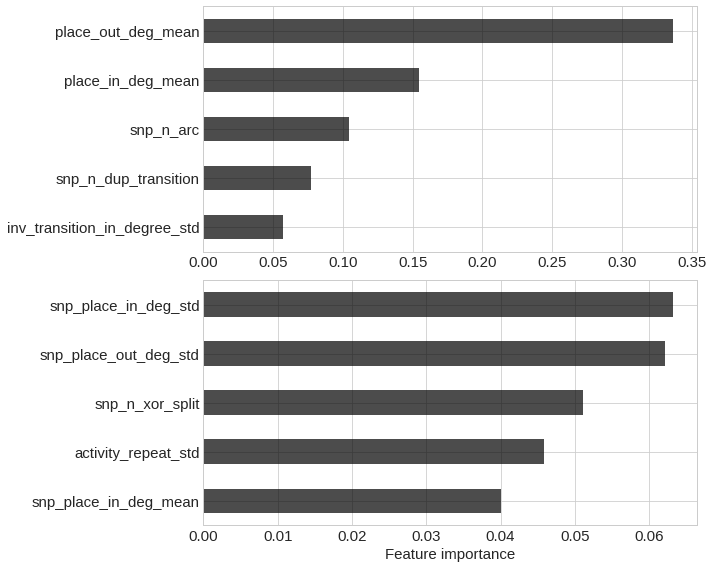

In [29]:
top_n = 5
top_5_feature_dt_df = feature_importance_df.sort_values('importance_dt', ascending=False).iloc[:top_n,:].sort_values('importance_dt')
top_5_feature_rf_df = feature_importance_df.sort_values('importance_rf', ascending=False).iloc[:top_n,:].sort_values('importance_rf')

fig, axes = plt.subplots(figsize=(10, 8), nrows=2)

top_5_feature_dt_df.plot.barh(y='importance_dt', ax=axes[0], color='black', alpha=0.7, legend=False, fontsize=15)
top_5_feature_rf_df.plot.barh(y='importance_rf', ax=axes[1], color='black', alpha=0.7, legend=False, fontsize=15)

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xlabel('Feature importance', fontsize=15)

for tick in axes[0].xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in axes[0].yaxis.get_major_ticks():
    tick.label.set_fontsize(15)

out_fp = './important-feature-top-5.svg'
fig.tight_layout()
fig.savefig(out_fp, bbox_inches='tight', rasterized=True)

### Check if there are differences between number of ingoing and outgoing arcs

In [42]:
feature_df = base_df.loc[:, idx[('model_trace_features'), ('snp_place_in_deg_mean', 'snp_place_out_deg_mean')]]
unequal_snp_in_out_degree_places = (feature_df.loc[:, ('model_trace_features', 'snp_place_in_deg_mean')] != feature_df.loc[:, ('model_trace_features', 'snp_place_out_deg_mean')])
feature_df.loc[unequal_snp_in_out_degree_places, :].head()

model_trace_features  \
                                              snp_place_in_deg_mean   
model log              decomposition SP label                         
net5  net5-60-10-l5000 sese_25       2                     2.159509   
                                     3                     1.959410   
                                     4                     1.920152   
                                     5                     1.858300   
                                     6                     1.775862   

                                                                      
                                              snp_place_out_deg_mean  
model log              decomposition SP label                         
net5  net5-60-10-l5000 sese_25       2                      2.131902  
                                     3                      1.955720  
                                     4                      1.923954  
                                     5                      1.854251  
                                     6                      1.780172

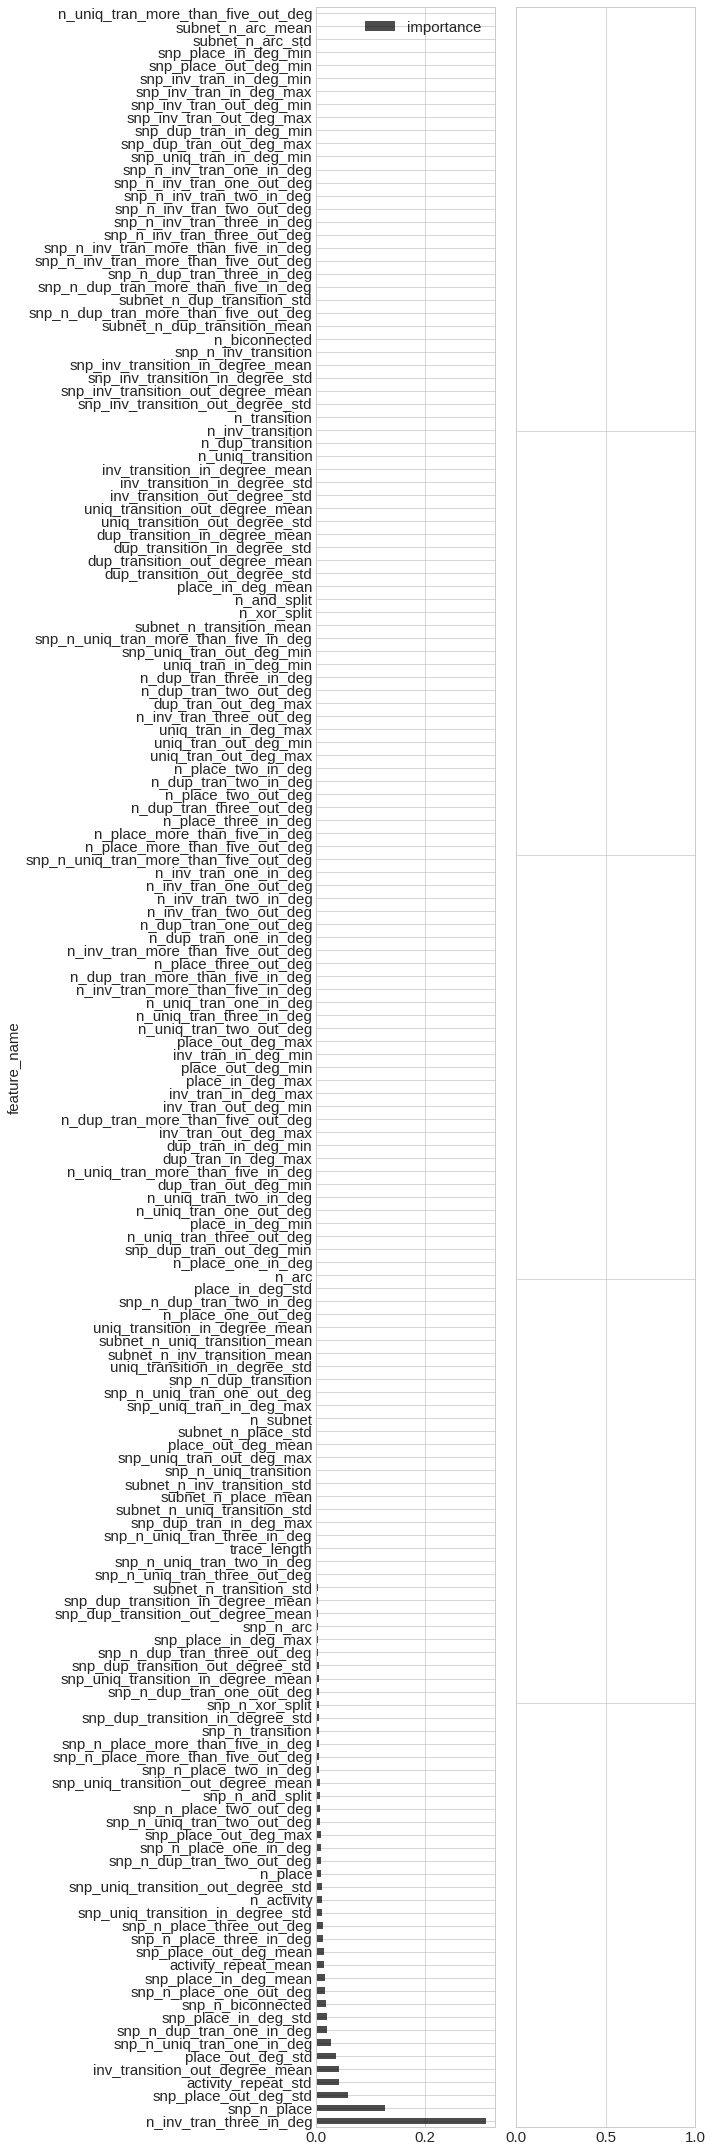

In [18]:
fig, axes = plt.subplots(figsize=(10, 30), ncols=2)
feature_importance_df.plot.barh(y='importance', ax=axes[0], color='black', alpha=0.7)
# feature_importance_df.plot.barh(y='importance_rf', ax=axes[1], color='black', alpha=ase0.7)
axes[1].set_yticklabels([])
axes[1].set_ylabel('')
fig.tight_layout()
# fig.savefig('./feature-importance.svg', bbox_inches='tight', rasterized=True)

### Plot the points

In [93]:
X_df.head()

snp_n_place  place_in_deg_mean
model log              decomposition SP label                                
net3  net3-10-60-l5000 sese_25       1               254.0           1.505618
                                     10              224.0           1.505618
                                     100             219.0           1.505618
                                     1000            217.0           1.505618
                                     1001            257.0           1.505618

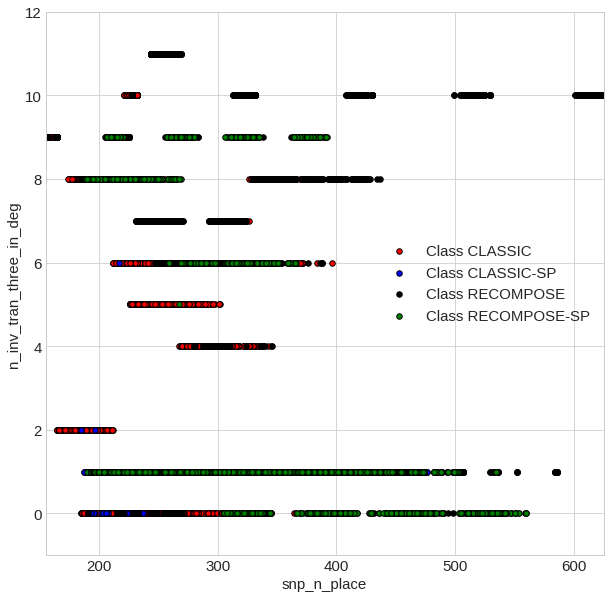

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))

class_names = [
    'CLASSIC', 'CLASSIC-SP', 'RECOMPOSE', 'RECOMPOSE-SP'
]

plot_colors = [
    'red', 'blue', 'black', 'green'
]
plot_step = 0.02

f0 = 'n_inv_tran_three_in_deg'
f1 = 'snp_n_place'
X_df = base_df.loc[:, idx[('model_trace_features'), (f0, f1)]]
X_df.columns = X_df.columns.droplevel(level=0)
X = X_df.values

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

# xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
#                     np.arange(y_min, y_max, plot_step))

# temp_df = base_df.loc[:, idx[('model_trace_features'), :]].copy()

# Z = dt.predict(np.c_[xx.ravel(), yy.ravel()])
# Z = Z.reshape(xx.shape)
# cs = ax.contourf(xx, yy, Z, cmap=plt.cm.Paired)

for i, n, c in zip(range(4), class_names, plot_colors):
    ind = np.where(base_df.loc[:, ('Min', 'Total Time including setup (s) - id')] == i)
    ax.scatter(X[ind, 0], X[ind, 1],
              c=c, cmap=plt.cm.Paired,
              s=30, edgecolor='k',
              label='Class {}'.format(n))
    
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
ax.set_xlabel(X_df.columns[0])
ax.set_ylabel(X_df.columns[1])
ax.legend()

In [119]:
base_df.head()

Cost of the alignment       \
                                                              astar inc3   
model log              decomposition SP label                              
net3  net3-10-60-l5000 sese_25       1                            0    0   
                                     10                           0    0   
                                     100                        192  192   
                                     1000                       198  198   
                                     1001                         0    0   

                                                                        \
                                              recomp-astar recomp-inc3   
model log              decomposition SP label                            
net3  net3-10-60-l5000 sese_25       1                 0.0         0.0   
                                     10                0.0         0.0   
                                     100             192.0       192.0   
                                     1000            198.0       198.0   
                                     1001              0.0         0.0   

                                              Heuristics computed       \
                                                            astar inc3   
model log              decomposition SP label                            
net3  net3-10-60-l5000 sese_25       1                          1    1   
                                     10                         1    1   
                                     100                     1149    8   
                                     1000                    1390    9   
                                     1001                       1    1   

                                                                        \
                                              recomp-astar recomp-inc3   
model log              decomposition SP label                            
net3  net3-10-60-l5000 sese_25       1                  74          75   
                                     10                 74          76   
                                     100              1241          83   
                                     1000             1478          86   
                                     1001               74          74   

                                              Heuristics derived       \
                                                           astar inc3   
model log              decomposition SP label                           
net3  net3-10-60-l5000 sese_25       1                        85   85   
                                     10                       48   48   
                                     100                     563  212   
                                     1000                    618  355   
                                     1001                     85   85   

                                                              ...                  \
                                                              ...                   
model log              decomposition SP label                 ...                   
net3  net3-10-60-l5000 sese_25       1                        ...                   
                                     10                       ...                   
                                     100                      ...                   
                                     1000                     ...                   
                                     1001                     ...                   

                                                     model_trace_features  \
                                              subnet_n_inv_transition_std   
model log              decomposition SP label                               
net3  net3-10-60-l5000 sese_25       1                           4.555543   
                                     10                          4.555543   
       

In [131]:
feature_importance_df.head()

importance_dt  importance_rf
feature_name                                       
snp_place_in_deg_std        0.027850       0.080896
snp_place_out_deg_std       0.022019       0.078487
snp_n_xor_split             0.019110       0.058881
activity_repeat_std         0.035446       0.050884
activity_repeat_mean        0.008276       0.041907

In [129]:
import collections as cols
import itertools as itls

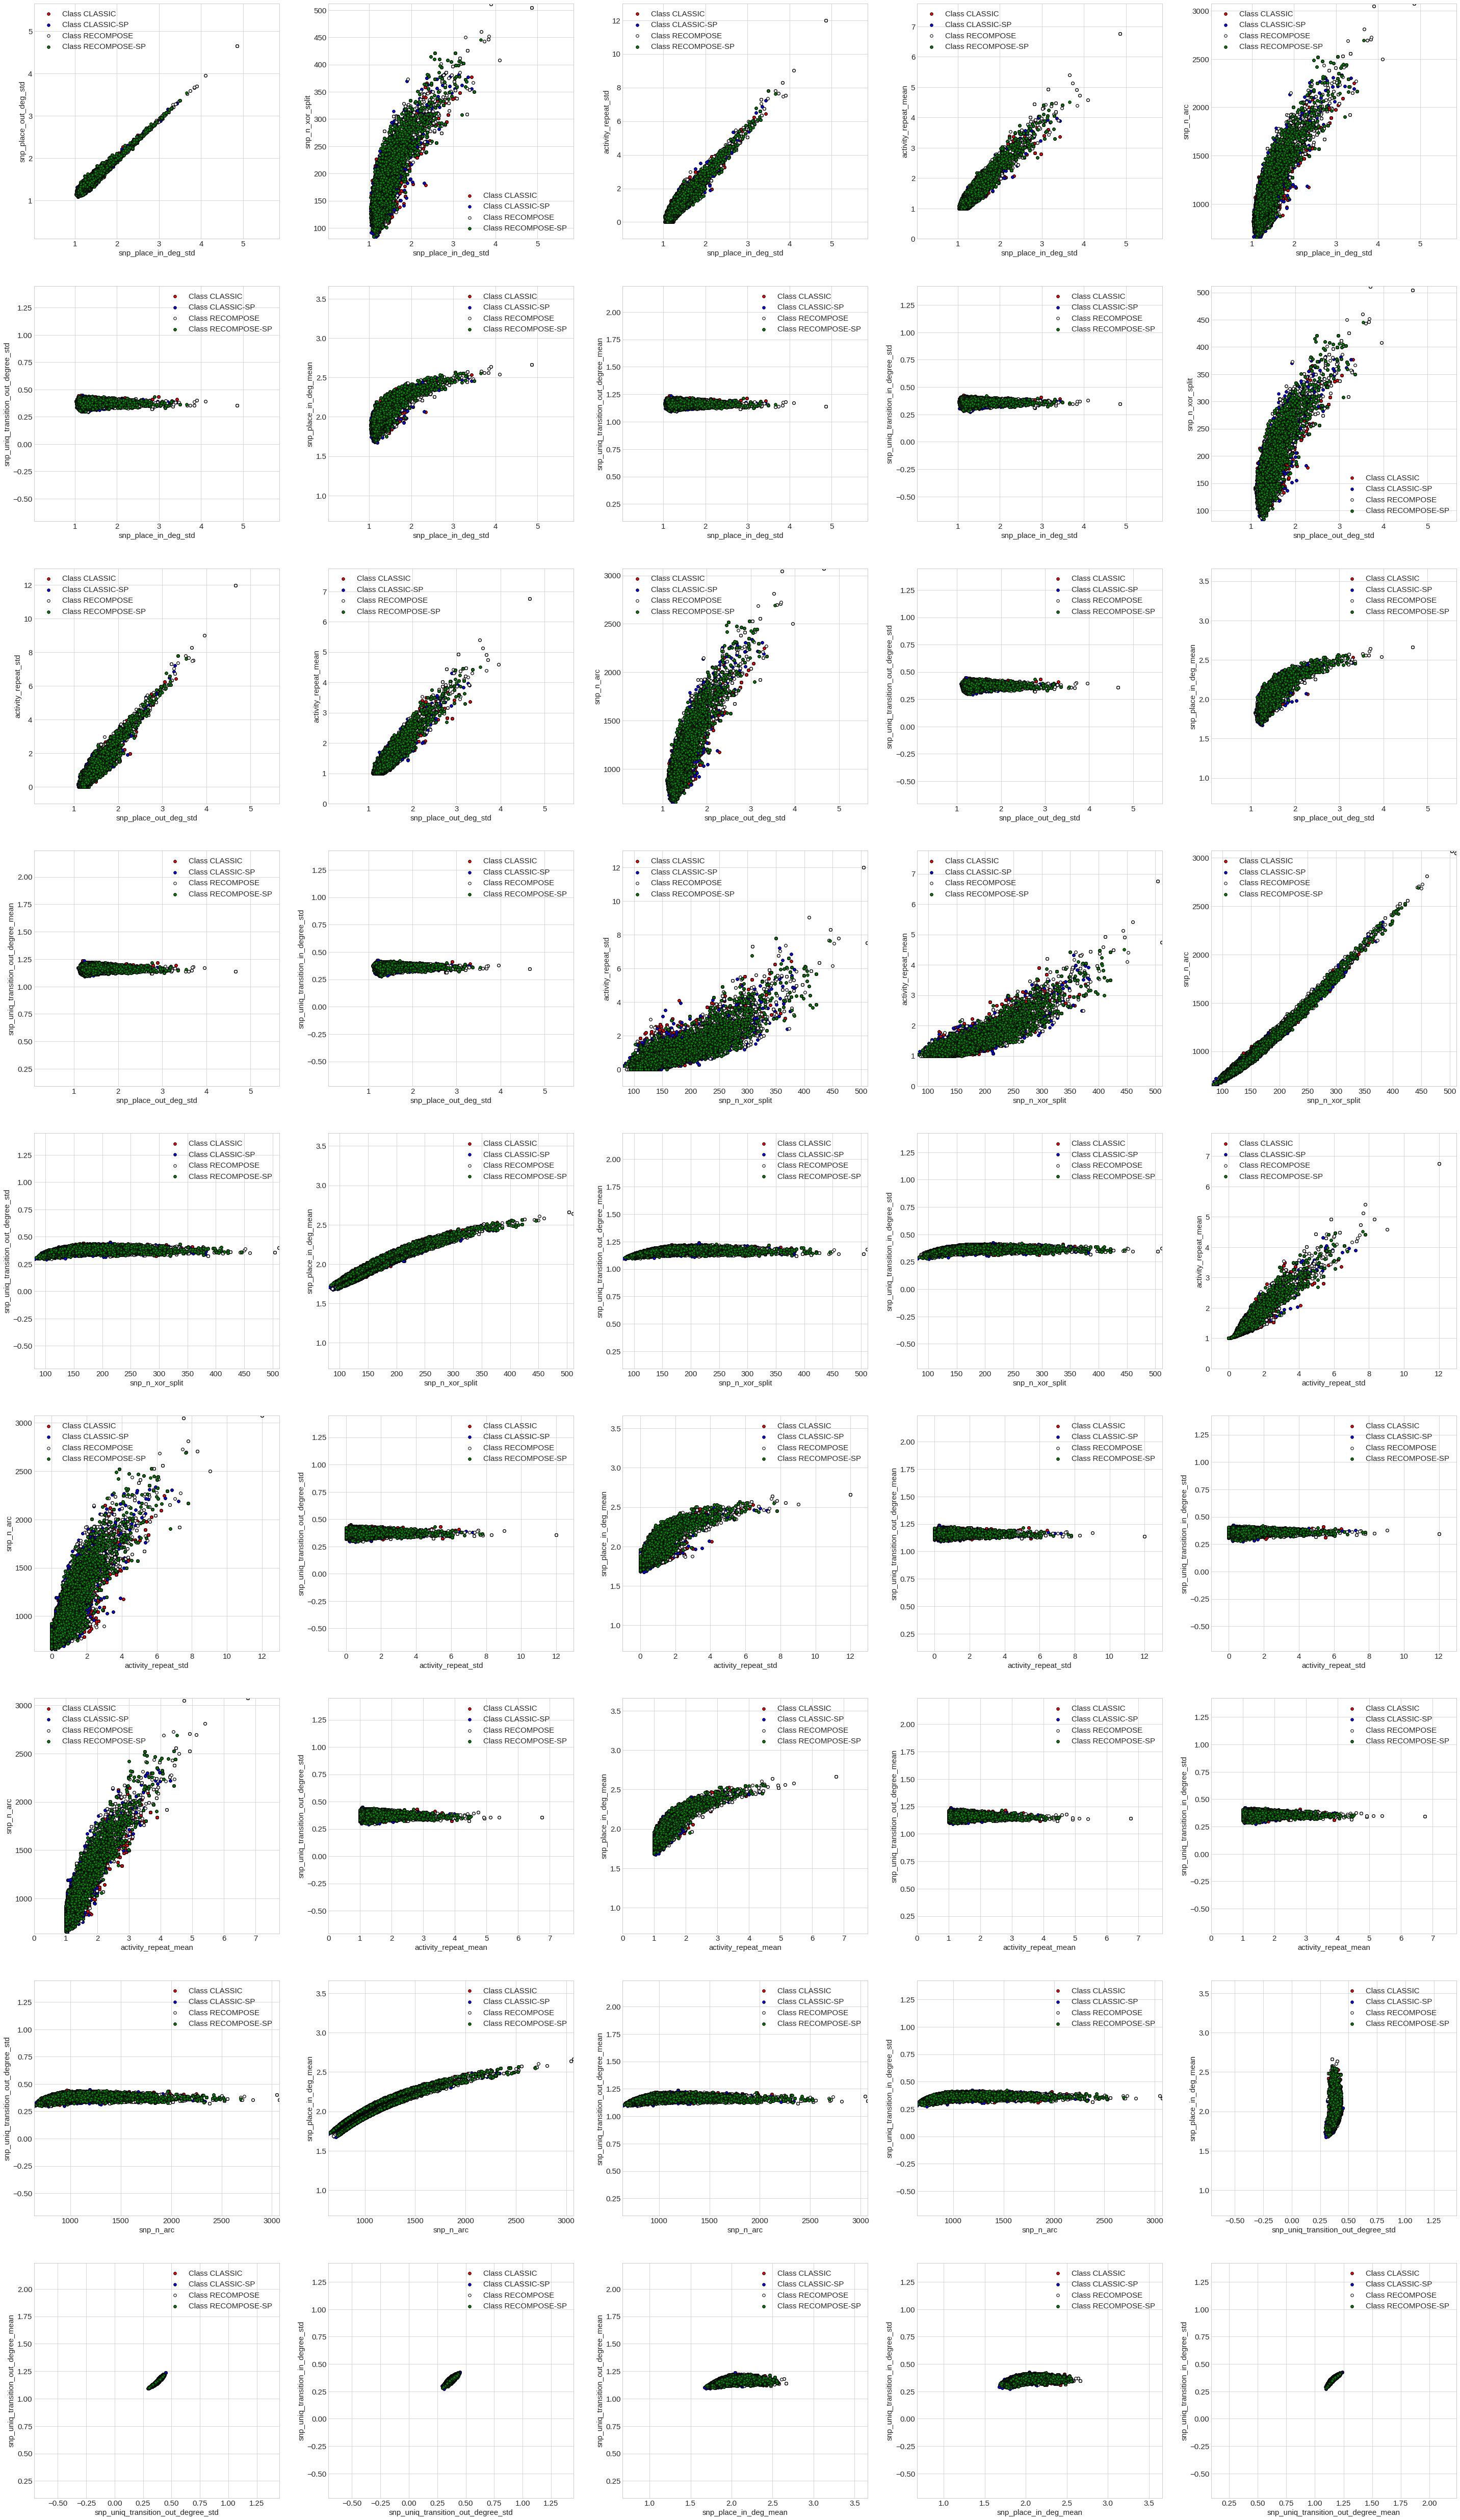

In [137]:
nrows = 9
ncols = 5

fig, axes = plt.subplots(figsize=(50, 90), nrows=nrows, ncols=ncols)

# combinations of top 10 features
top_10_features = feature_importance_df.sort_values('importance_rf', ascending=False).index[:10]

feature_combos = itls.combinations(top_10_features, 2)

class_names = [
    'CLASSIC', 'CLASSIC-SP', 'RECOMPOSE', 'RECOMPOSE-SP'
]

plot_colors = [
    'red', 'blue', 'white', 'green'
]
plot_step = 0.02

filtered_df = base_df[base_df.index.map(lambda x: x[0].startswith('net'))] #.iloc[:10, :]

row, col = 0, 0

for f0, f1 in feature_combos:
    ax = axes[row, col]
    row = row if col < 4 else row + 1
    col = col + 1 if col < 4 else 0

    X_df = filtered_df.loc[:, idx[('model_trace_features'), (f0, f1)]]
    X_df.columns = X_df.columns.droplevel(level=0)
    X_df = X_df[[f0, f1]]
    X = X_df.values

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    # xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
    #                     np.arange(y_min, y_max, plot_step))

    # temp_df = base_df.loc[:, idx[('model_trace_features'), :]].copy()

    # Z = dt.predict(np.c_[xx.ravel(), yy.ravel()])
    # Z = Z.reshape(xx.shape)
    # cs = ax.contourf(xx, yy, Z, cmap=plt.cm.Paired)

    for i, n, c in zip(range(4), class_names, plot_colors):
        ind = np.where(filtered_df.loc[:, ('Min', 'Total Time including setup (s) - id')] == i)
        ax.scatter(X[ind, 0], X[ind, 1],
                  c=c, cmap=plt.cm.Paired,
                  s=30, edgecolor='k',
                  label='Class {}'.format(n))

    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    ax.set_xlabel(X_df.columns[0])
    ax.set_ylabel(X_df.columns[1])
    ax.legend()

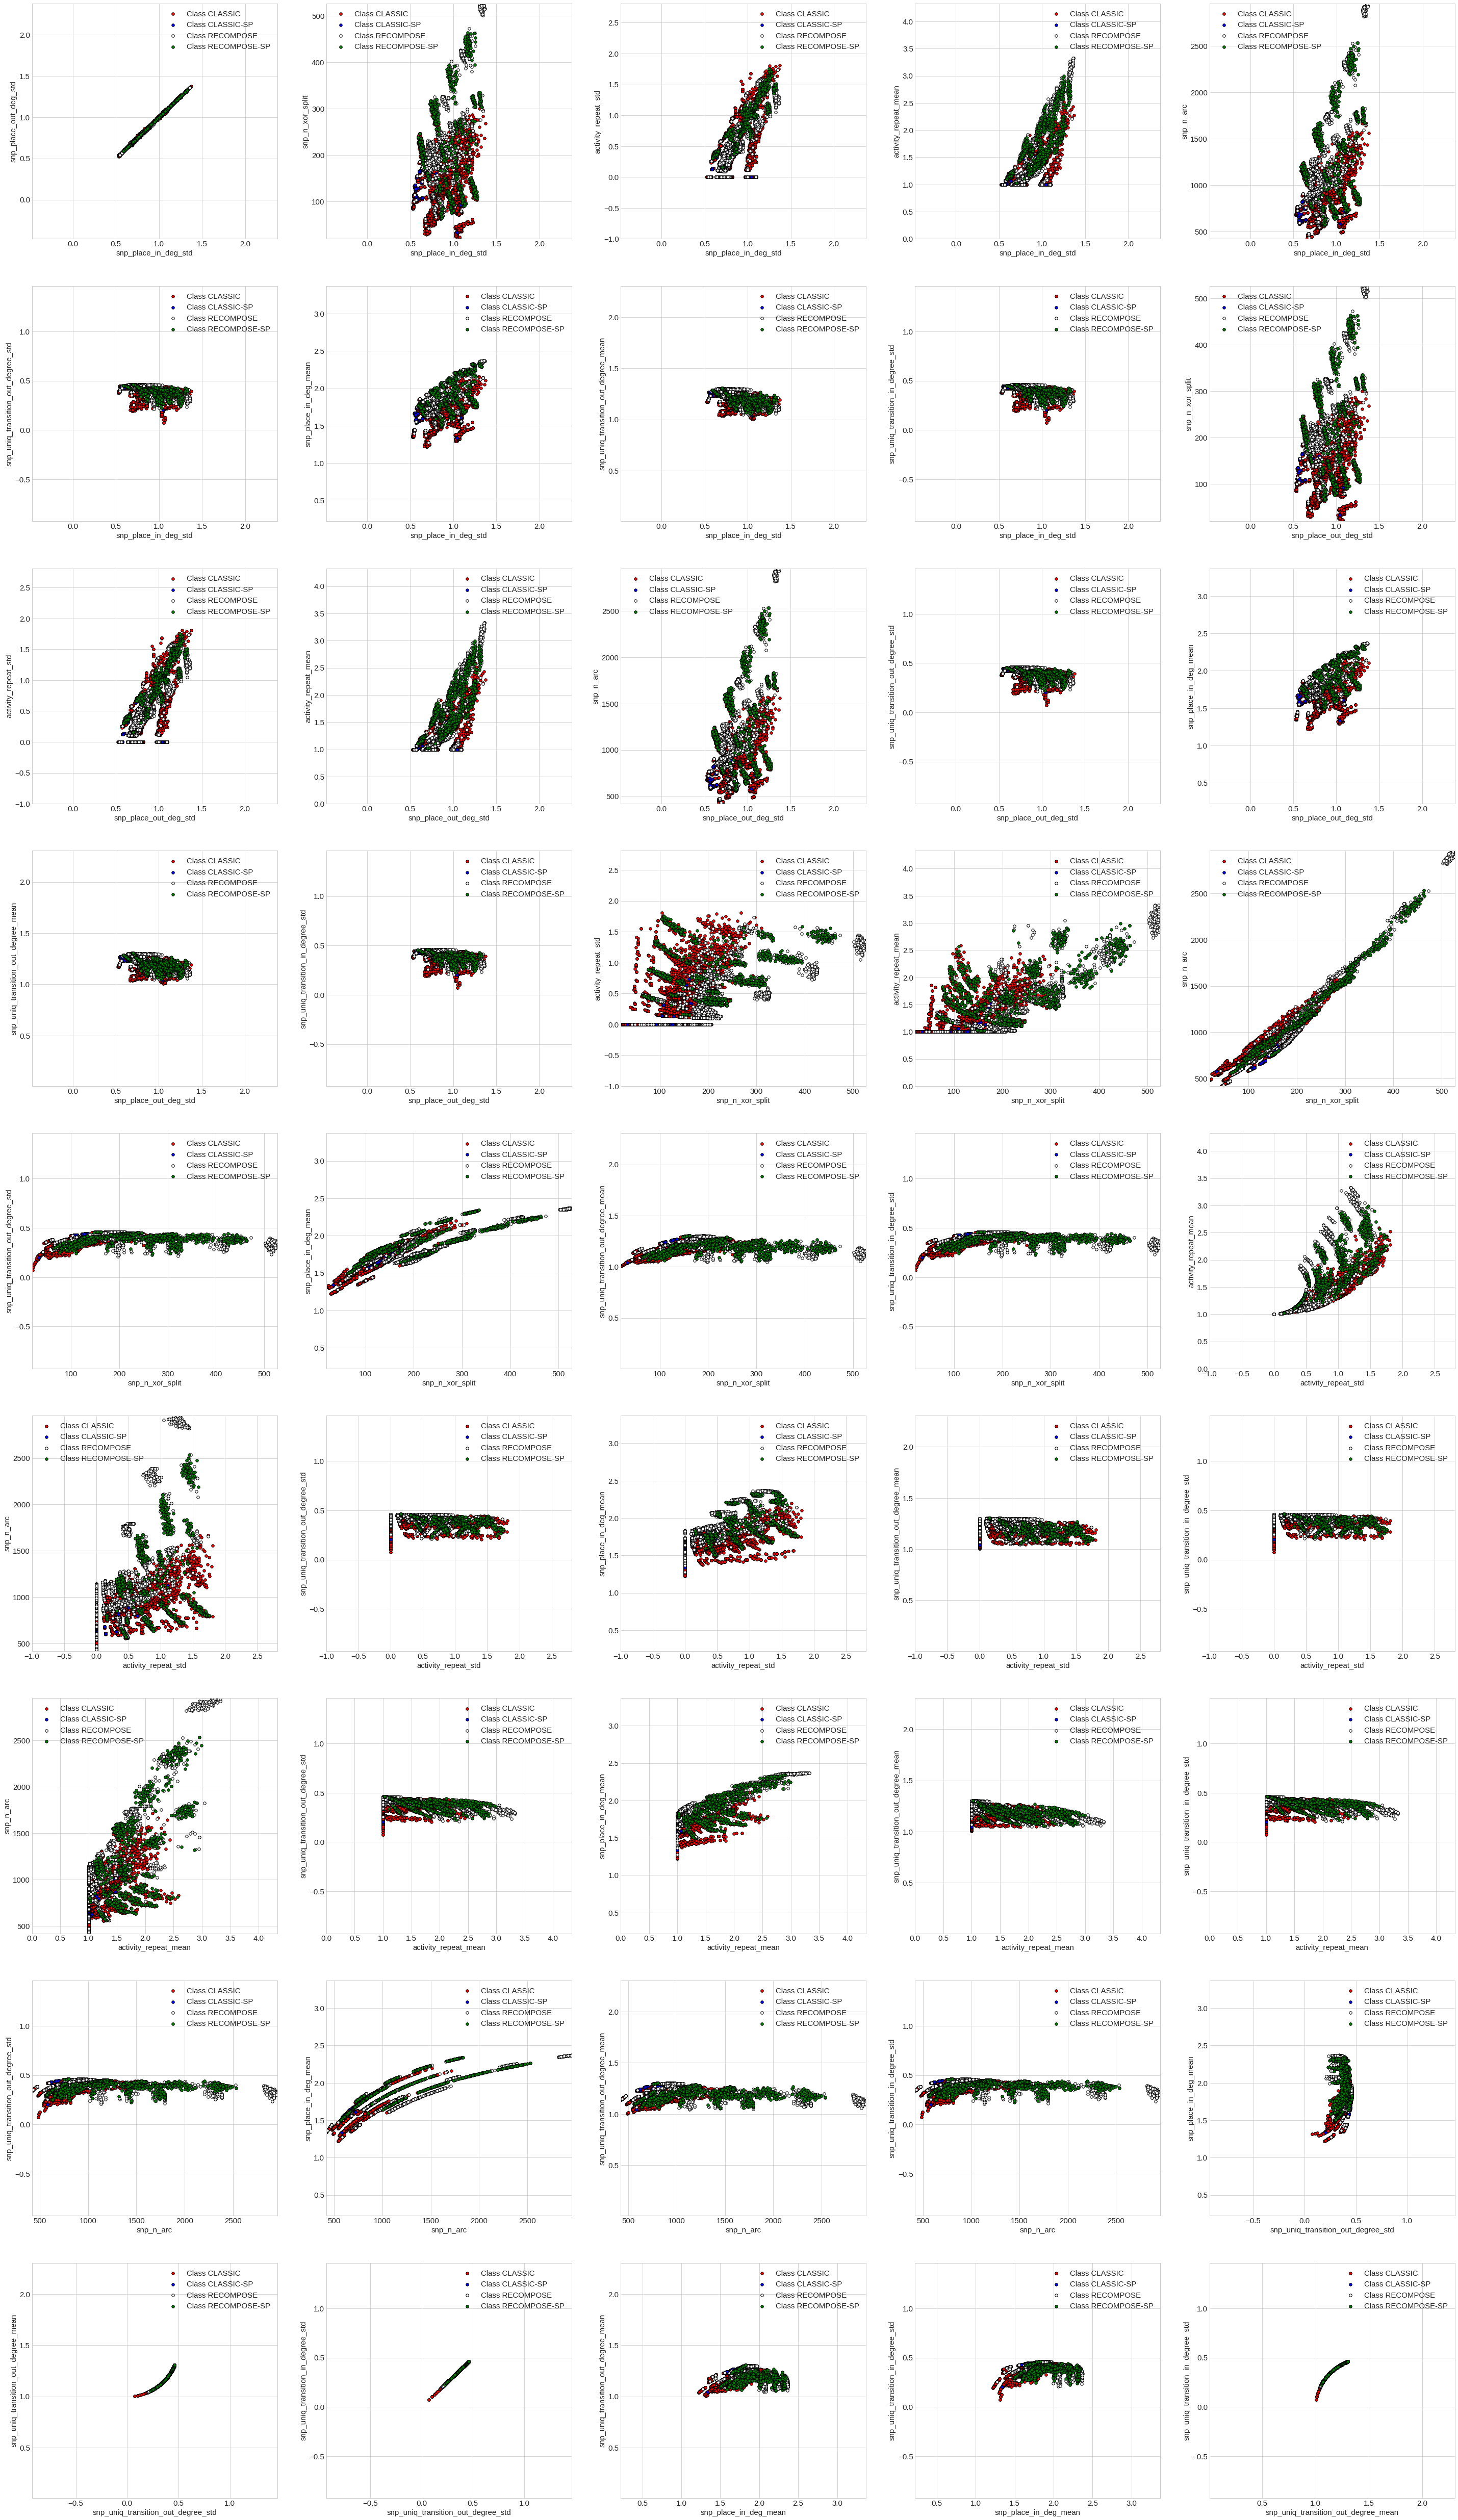

In [139]:
nrows = 9
ncols = 5

fig, axes = plt.subplots(figsize=(50, 90), nrows=nrows, ncols=ncols)

# combinations of top 10 features
top_10_features = feature_importance_df.sort_values('importance_rf', ascending=False).index[:10]

feature_combos = itls.combinations(top_10_features, 2)

class_names = [
    'CLASSIC', 'CLASSIC-SP', 'RECOMPOSE', 'RECOMPOSE-SP'
]

plot_colors = [
    'red', 'blue', 'white', 'green'
]
plot_step = 0.02

filtered_df = base_df[base_df.index.map(lambda x: not x[0].startswith('net'))] #.iloc[:10, :]

row, col = 0, 0

for f0, f1 in feature_combos:
    ax = axes[row, col]
    row = row if col < 4 else row + 1
    col = col + 1 if col < 4 else 0

    X_df = filtered_df.loc[:, idx[('model_trace_features'), (f0, f1)]]
    X_df.columns = X_df.columns.droplevel(level=0)
    X_df = X_df[[f0, f1]]
    X = X_df.values

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    # xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
    #                     np.arange(y_min, y_max, plot_step))

    # temp_df = base_df.loc[:, idx[('model_trace_features'), :]].copy()

    # Z = dt.predict(np.c_[xx.ravel(), yy.ravel()])
    # Z = Z.reshape(xx.shape)
    # cs = ax.contourf(xx, yy, Z, cmap=plt.cm.Paired)

    for i, n, c in zip(range(4), class_names, plot_colors):
        ind = np.where(filtered_df.loc[:, ('Min', 'Total Time including setup (s) - id')] == i)
        ax.scatter(X[ind, 0], X[ind, 1],
                  c=c, cmap=plt.cm.Paired,
                  s=30, edgecolor='k',
                  label='Class {}'.format(n))

    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    ax.set_xlabel(X_df.columns[0])
    ax.set_ylabel(X_df.columns[1])
    ax.legend()

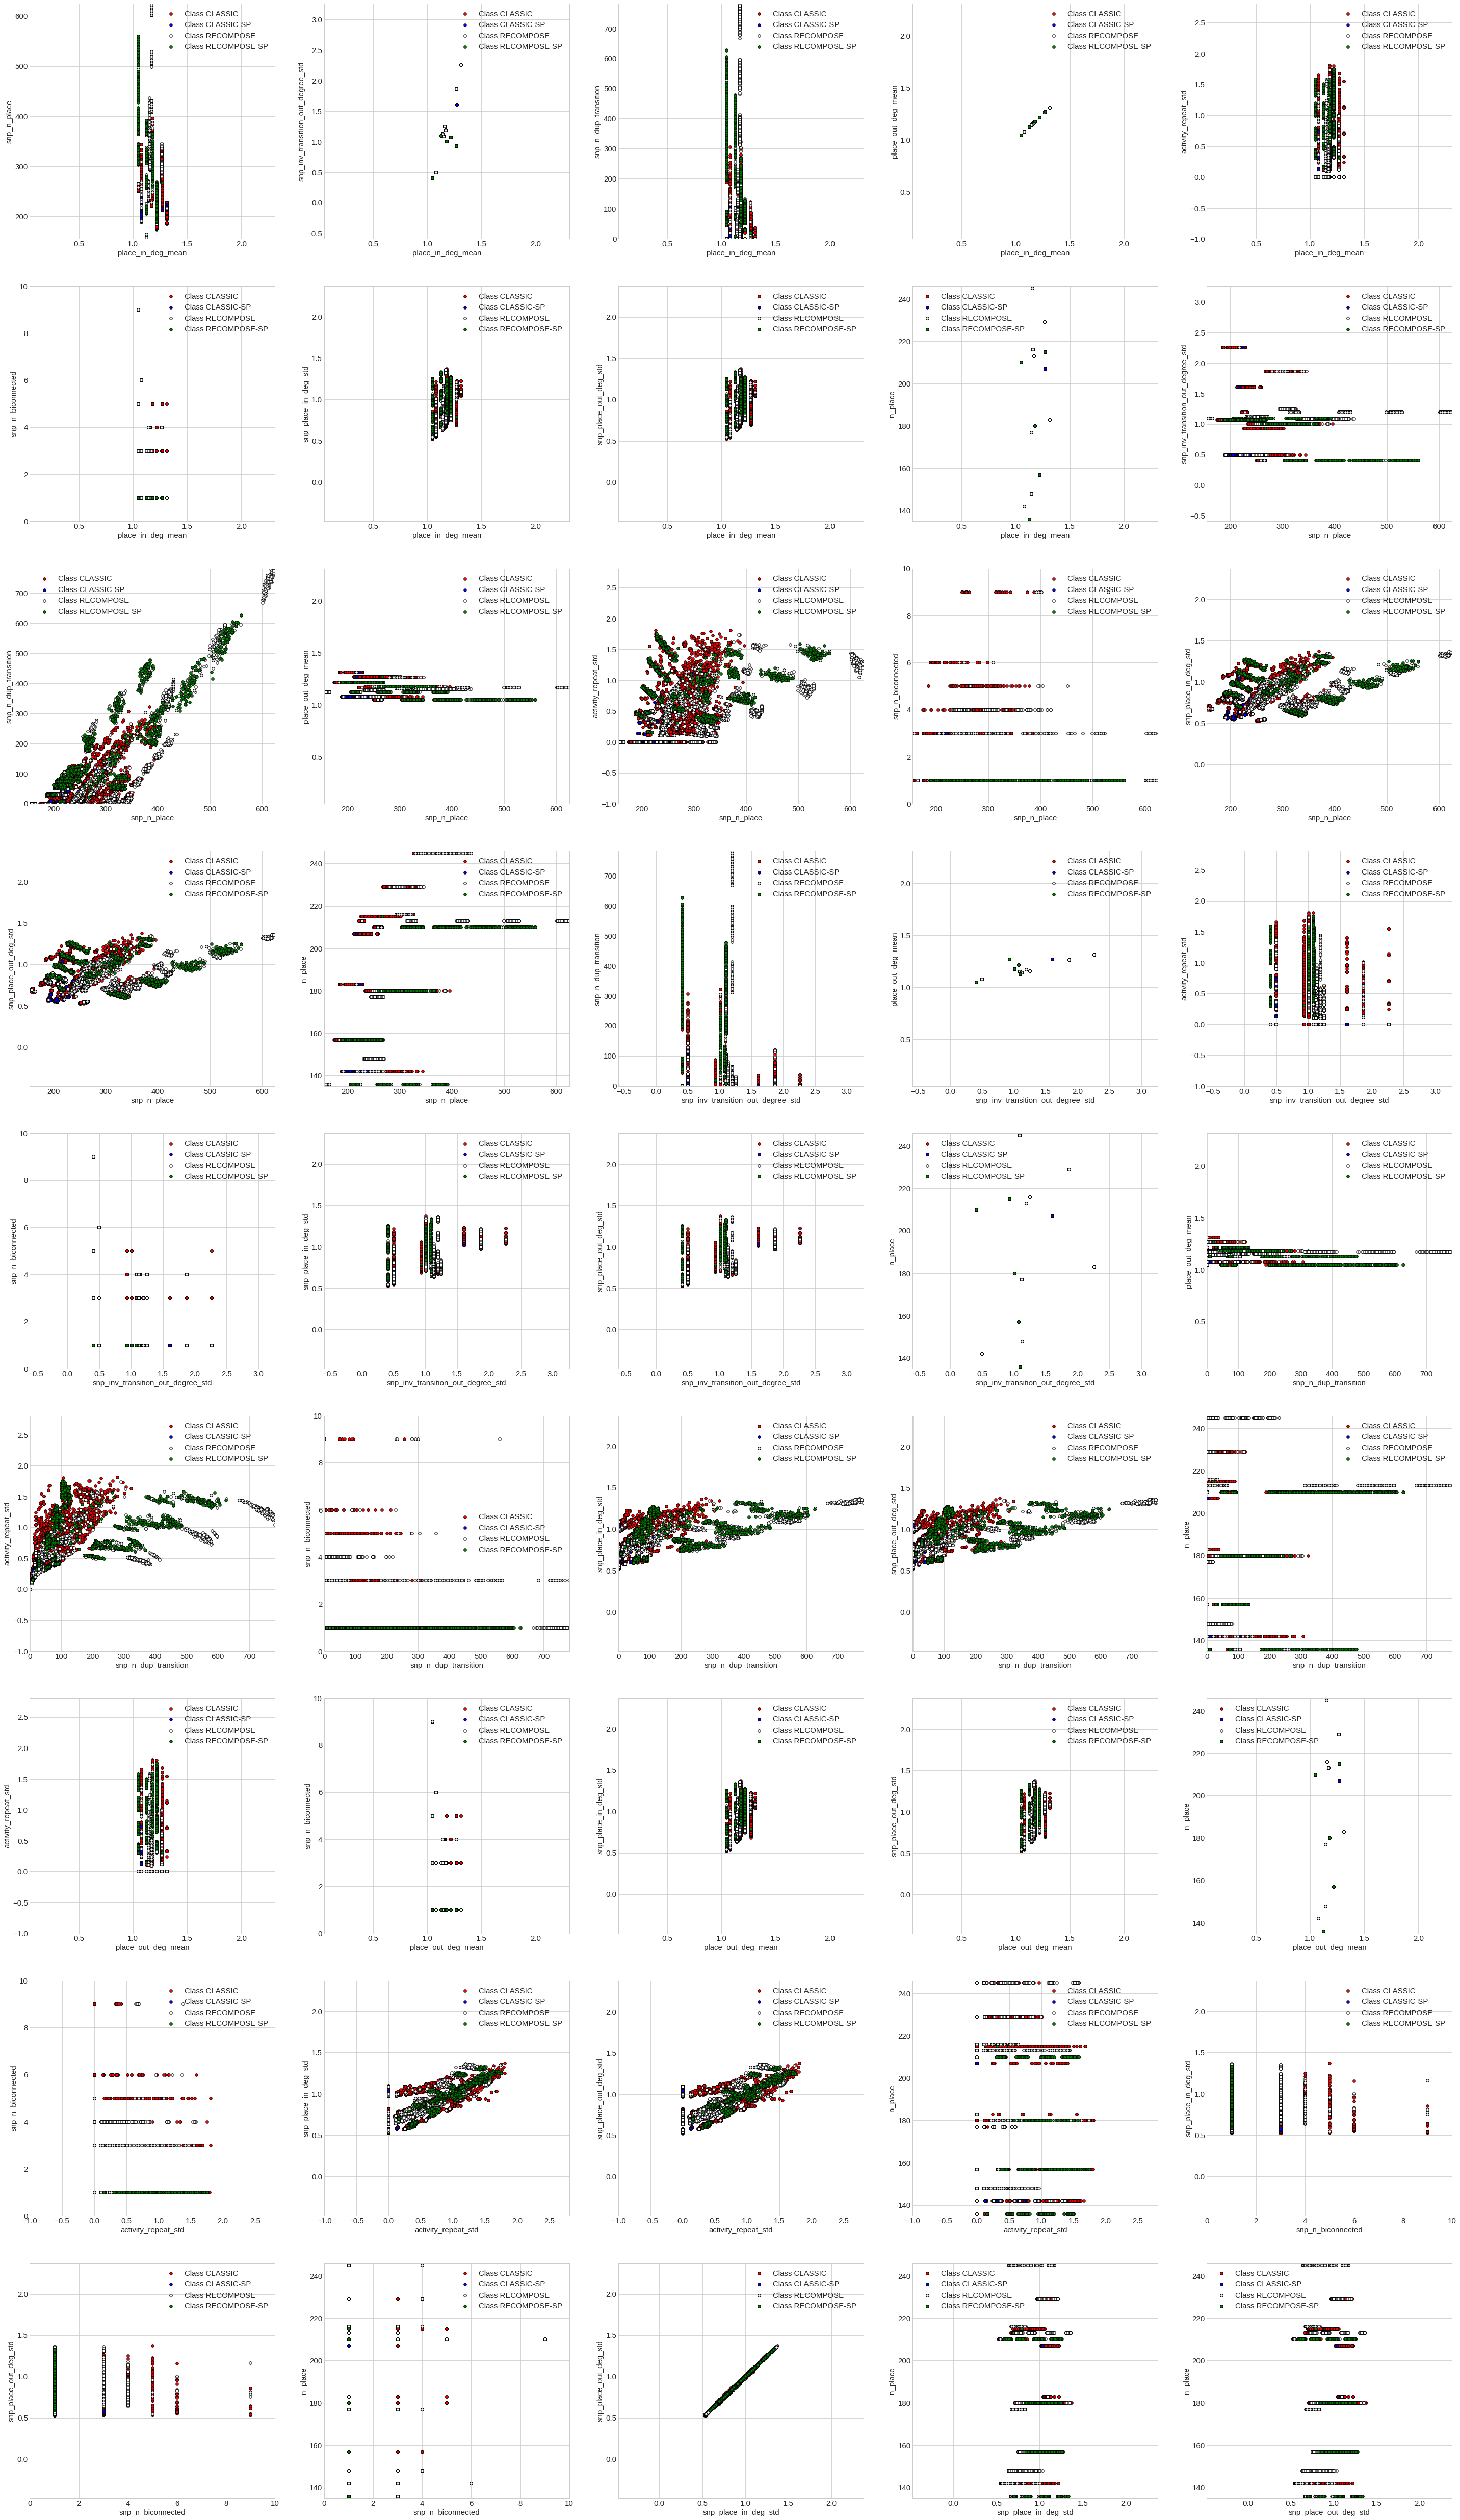

In [140]:
nrows = 9
ncols = 5

fig, axes = plt.subplots(figsize=(50, 90), nrows=nrows, ncols=ncols)

# combinations of top 10 features
top_10_features = feature_importance_df.sort_values('importance_dt', ascending=False).index[:10]

feature_combos = itls.combinations(top_10_features, 2)

class_names = [
    'CLASSIC', 'CLASSIC-SP', 'RECOMPOSE', 'RECOMPOSE-SP'
]

plot_colors = [
    'red', 'blue', 'white', 'green'
]
plot_step = 0.02

filtered_df = base_df[base_df.index.map(lambda x: not x[0].startswith('net'))] #.iloc[:10, :]

row, col = 0, 0

for f0, f1 in feature_combos:
    ax = axes[row, col]
    row = row if col < 4 else row + 1
    col = col + 1 if col < 4 else 0

    X_df = filtered_df.loc[:, idx[('model_trace_features'), (f0, f1)]]
    X_df.columns = X_df.columns.droplevel(level=0)
    X_df = X_df[[f0, f1]]
    X = X_df.values

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    # xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
    #                     np.arange(y_min, y_max, plot_step))

    # temp_df = base_df.loc[:, idx[('model_trace_features'), :]].copy()

    # Z = dt.predict(np.c_[xx.ravel(), yy.ravel()])
    # Z = Z.reshape(xx.shape)
    # cs = ax.contourf(xx, yy, Z, cmap=plt.cm.Paired)

    for i, n, c in zip(range(4), class_names, plot_colors):
        ind = np.where(filtered_df.loc[:, ('Min', 'Total Time including setup (s) - id')] == i)
        ax.scatter(X[ind, 0], X[ind, 1],
                  c=c, cmap=plt.cm.Paired,
                  s=30, edgecolor='k',
                  label='Class {}'.format(n))

    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    ax.set_xlabel(X_df.columns[0])
    ax.set_ylabel(X_df.columns[1])
    ax.legend()

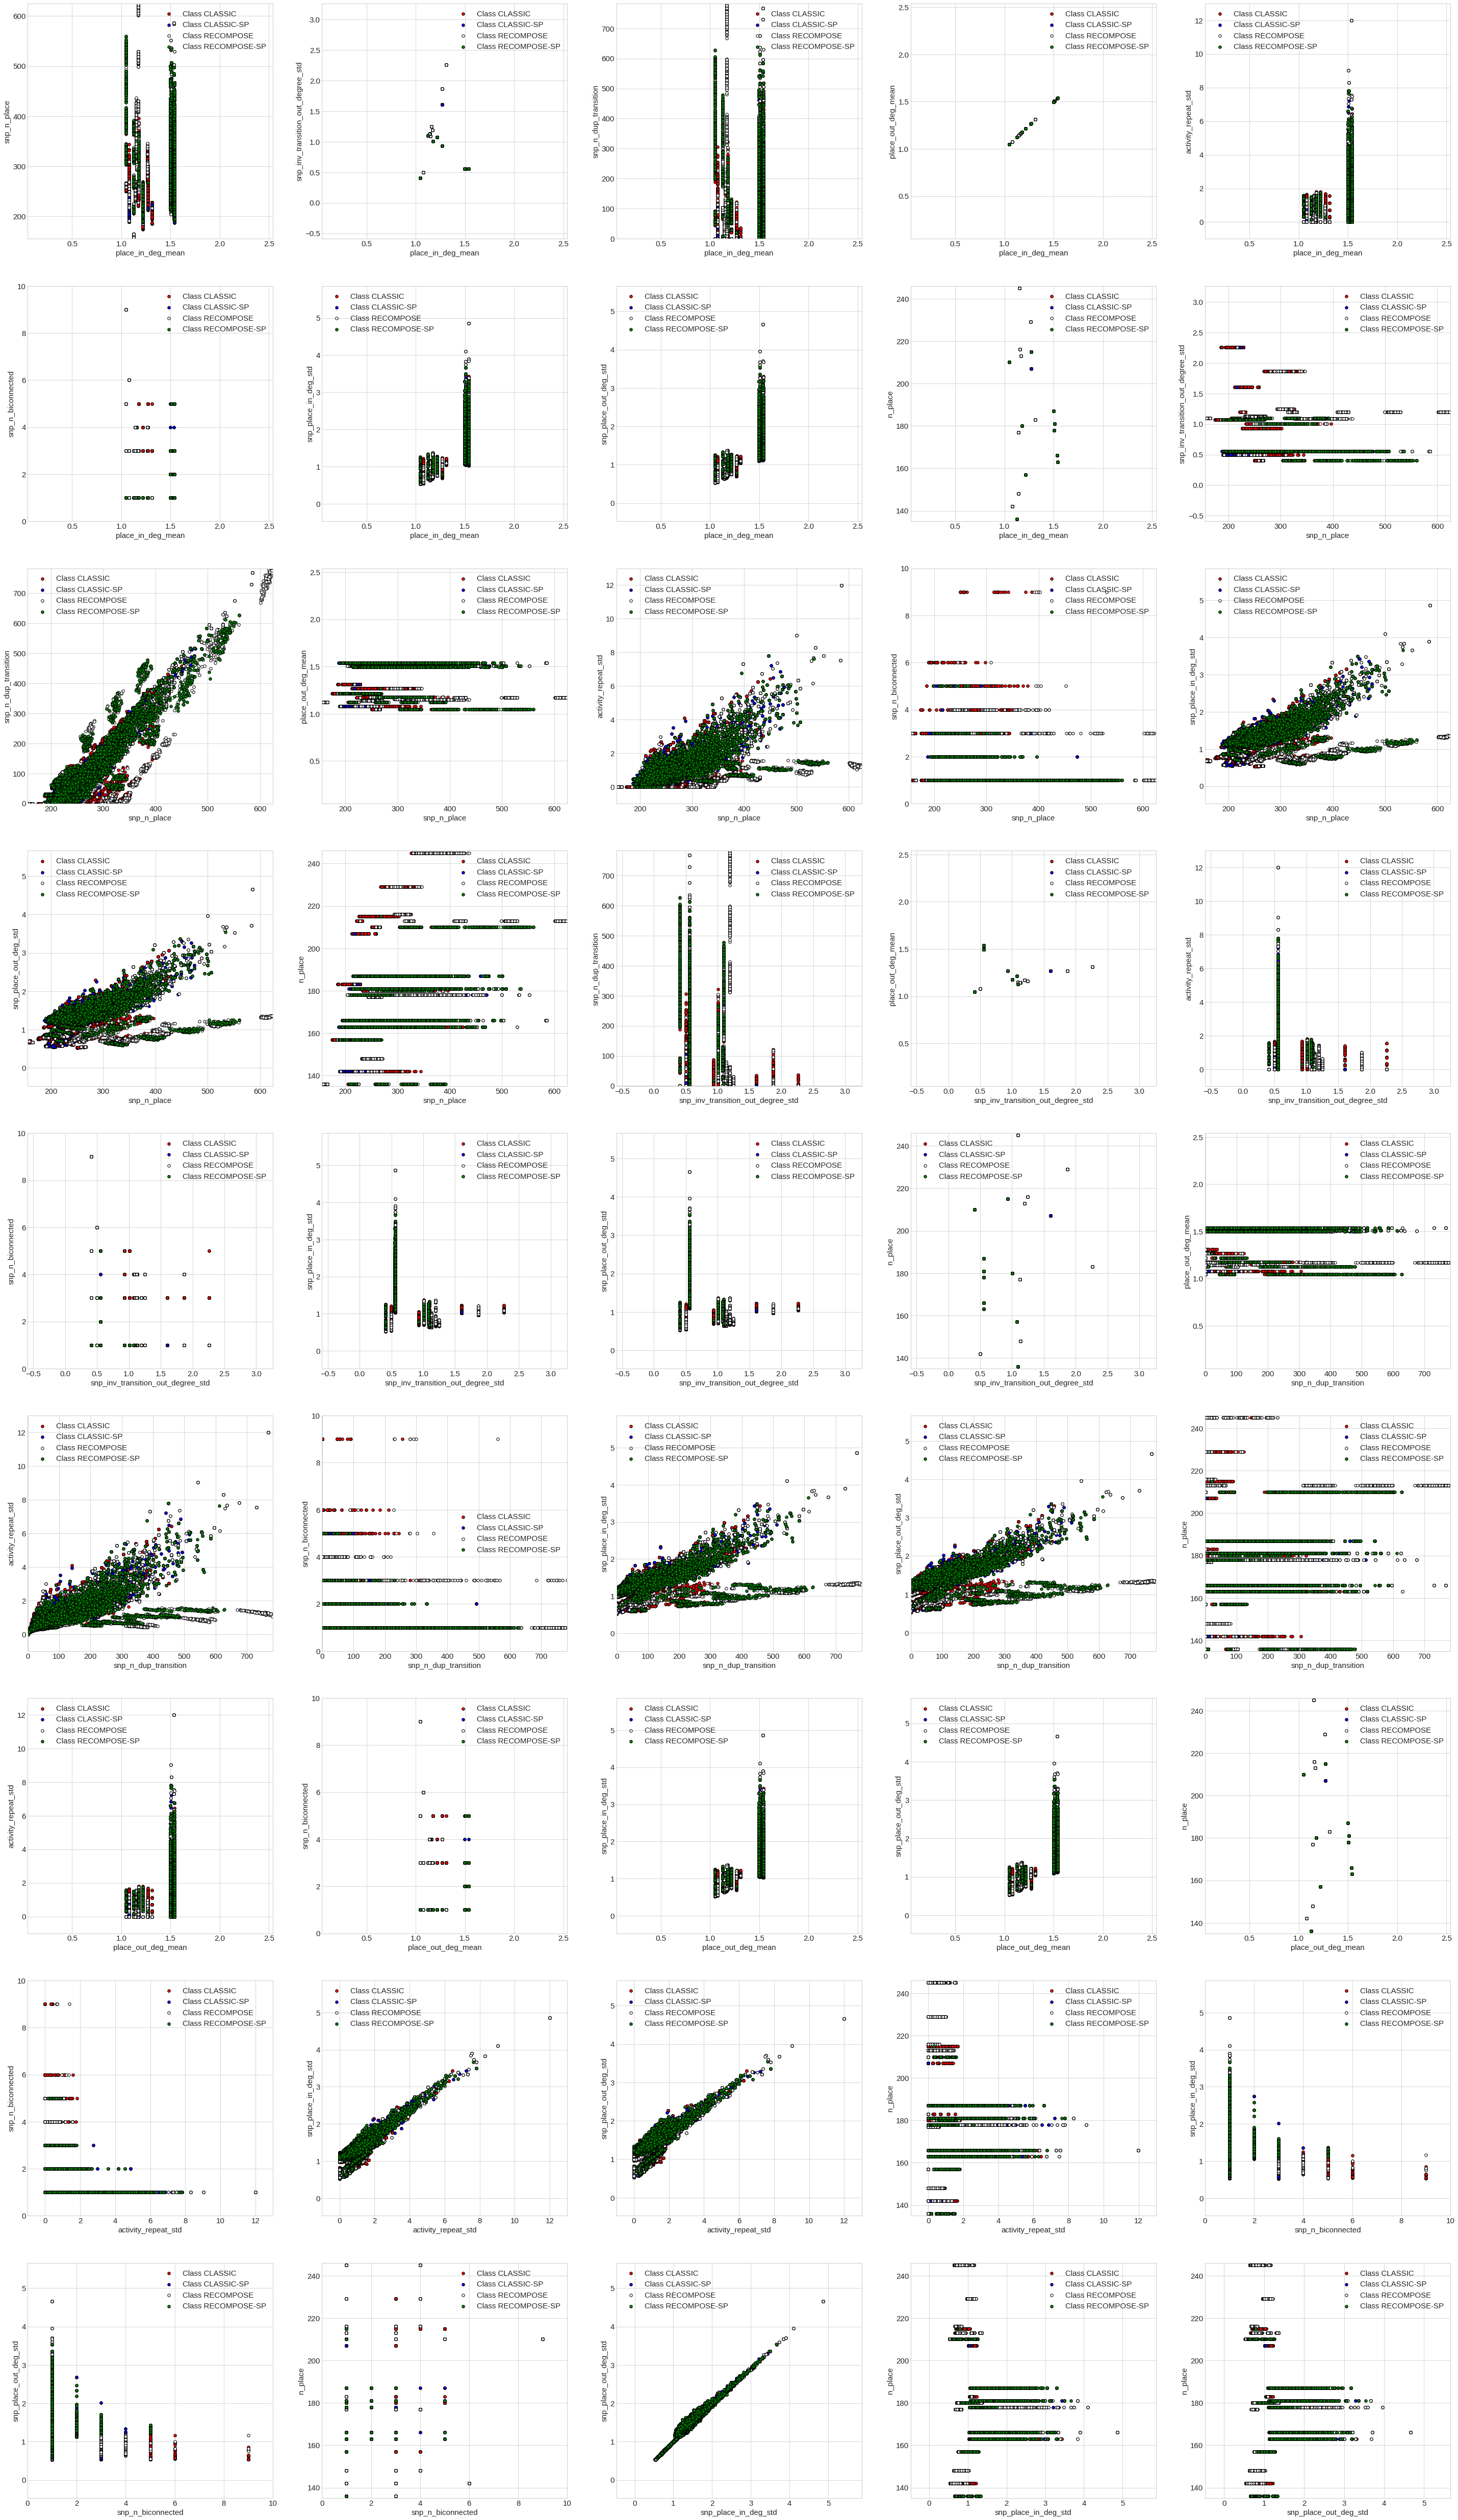

In [141]:
nrows = 9
ncols = 5

fig, axes = plt.subplots(figsize=(50, 90), nrows=nrows, ncols=ncols)

# combinations of top 10 features
top_10_features = feature_importance_df.sort_values('importance_dt', ascending=False).index[:10]

feature_combos = itls.combinations(top_10_features, 2)

class_names = [
    'CLASSIC', 'CLASSIC-SP', 'RECOMPOSE', 'RECOMPOSE-SP'
]

plot_colors = [
    'red', 'blue', 'white', 'green'
]
plot_step = 0.02

# filtered_df = base_df[base_df.index.map(lambda x: not x[0].startswith('net'))] #.iloc[:10, :]
filtered_df = base_df

row, col = 0, 0

for f0, f1 in feature_combos:
    ax = axes[row, col]
    row = row if col < 4 else row + 1
    col = col + 1 if col < 4 else 0

    X_df = filtered_df.loc[:, idx[('model_trace_features'), (f0, f1)]]
    X_df.columns = X_df.columns.droplevel(level=0)
    X_df = X_df[[f0, f1]]
    X = X_df.values

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    # xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
    #                     np.arange(y_min, y_max, plot_step))

    # temp_df = base_df.loc[:, idx[('model_trace_features'), :]].copy()

    # Z = dt.predict(np.c_[xx.ravel(), yy.ravel()])
    # Z = Z.reshape(xx.shape)
    # cs = ax.contourf(xx, yy, Z, cmap=plt.cm.Paired)

    for i, n, c in zip(range(4), class_names, plot_colors):
        ind = np.where(filtered_df.loc[:, ('Min', 'Total Time including setup (s) - id')] == i)
        ax.scatter(X[ind, 0], X[ind, 1],
                  c=c, cmap=plt.cm.Paired,
                  s=30, edgecolor='k',
                  label='Class {}'.format(n))

    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    ax.set_xlabel(X_df.columns[0])
    ax.set_ylabel(X_df.columns[1])
    ax.legend()

### Confidence interval of the mean in degrees of places under different classes

In [211]:
import scipy.stats as stats

In [244]:
algos = [
    'astar', 'inc3', 'recomp-astar', 'recomp-inc3'
]

compute_se = lambda vals: np.std(vals, ddof=1) / (len(vals) ** 0.5)
compute_se.__name__ = 'se'

alpha = 0.01
conf_delta = lambda vals: stats.norm.cdf(alpha / 2) * compute_se(vals)
conf_delta.__name__ = 'conf_delta'

stats_list = []


col = 'snp_place_out_deg_mean'

for algo in algos:
    # valid alignment rows
    is_valid = base_df.loc[:, ('is_valid', 'all')] == True
    filtered_df = base_df.loc[is_valid, idx[('Min', 'model_trace_features'), ('Total Time including setup (s)', col)]]
    filtered_df.columns = filtered_df.columns.droplevel()
    filtered_df.columns = ['min_total_time', col]
    
    grouped = filtered_df.groupby('min_total_time')
    stats_algo = grouped.get_group(algo).agg({col: [len, np.mean, np.std, np.min, np.max, compute_se, conf_delta]})
    stats_list.append(stats_algo)


place_out_deg_df = pd.concat(stats_list, axis=1, keys=algos).T.swaplevel()
# place_out_deg_df.to_csv('./place-out-deg.csv', float_format='%.2f')
place_out_deg_df

/home/jonathan/github-repos/2018/2018-09-26_align-algo-clf/alignclf-venv/lib/python3.5/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)


len      mean       std      amin  \
snp_place_out_deg_mean astar         174770.0  1.891487  0.144973  1.221719   
                       inc3           39630.0  1.912961  0.118515  1.336406   
                       recomp-astar   17013.0  1.925614  0.202114  1.276316   
                       recomp-inc3    19940.0  1.962403  0.136543  1.494681   

                                         amax        se  conf_delta  
snp_place_out_deg_mean astar         2.581911  0.000347    0.000174  
                       inc3          2.581911  0.000595    0.000299  
                       recomp-astar  2.581911  0.001550    0.000778  
                       recomp-inc3   2.492784  0.000967    0.000485

In [243]:
col_stats_dict = dict()
col_stats_dict['stat'] = ['count', 'mean', 'std', 'se', 'conf_delta']

for algo in algos:
    invalid = base_df.loc[:, ('is_valid', algo)] == False
    col_vals = base_df.loc[invalid, ('model_trace_features', col)]
    
    if col_vals.shape[0] < 1:
        continue
    
    col_stats = [len(col_vals), np.mean(col_vals), np.std(col_vals, ddof=1), compute_se(col_vals), conf_delta(col_vals)]
    col_stats_dict[algo] = col_stats

invalid_place_out_deg_df = pd.DataFrame(col_stats_dict).set_index('stat').T
invalid_place_out_deg_df.to_csv('./invalid-place-out-deg.csv', float_format='%.2f')
invalid_place_out_deg_df

stat   count      mean       std        se  conf_delta
astar   78.0  2.337847  0.086746  0.009822    0.004931
inc3    54.0  2.182501  0.127653  0.017371    0.008720

In [195]:
algos = [
    'astar', 'inc3', 'recomp-astar', 'recomp-inc3'
]

compute_se = lambda vals: np.std(vals, ddof=1) / (len(vals) ** 0.5)
compute_se.__name__ = 'se'

alpha = 0.01
conf_delta = lambda vals: stats.norm.cdf(alpha / 2) * compute_se(vals)
conf_delta.__name__ = 'conf_delta'

stats_list = []

base_df.loc[:, ('is_valid', 'all')] = base_df.loc[:, idx[('is_valid'), ('astar', 'inc3', 'recomp-astar', 'recomp-inc3')]].apply(lambda row: row.all(), axis=1)

for algo in algos:
    # valid alignment rows
    is_valid = base_df.loc[:, ('is_valid', 'all')] == True
    filtered_df = base_df.loc[is_valid, idx[('Min', 'model_trace_features'), ('Total Time including setup (s)', 'snp_place_in_deg_mean')]]
    filtered_df.columns = filtered_df.columns.droplevel()
    filtered_df.columns = ['min_total_time', 'place_in_deg_mean']
    
    grouped = filtered_df.groupby('min_total_time')
    stats_algo = grouped.get_group(algo).agg({'place_in_deg_mean': [np.mean, np.std, compute_se, conf_delta]})
    stats_list.append(stats_algo)


pd.concat(stats_list, axis=1, keys=algos)

astar              inc3      recomp-astar  \
           place_in_deg_mean place_in_deg_mean place_in_deg_mean   
mean                1.896079          1.917990          1.933229   
std                 0.150358          0.124654          0.213170   
se                  0.000360          0.000626          0.001634   
conf_delta          0.000181          0.000314          0.000820   

                 recomp-inc3  
           place_in_deg_mean  
mean                1.969476  
std                 0.144024  
se                  0.001020  
conf_delta          0.000512